In [1]:
import pickle
import glob
import h5py
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter, find_peaks, peak_widths

from general.misc import create_folder
from general.spectrum_modeling import density_KIinH2O
from general.wb_functions import (
                                  convert2EPL,
                                  ellipse,
                                  ideal_ellipse,
                                  plot_ellipse,
                                  plot_widths
                                  )


prj_fld = '/mnt/r/X-ray Tomography/2018_DataSets/SprayCalibration'

In [2]:
def proc_data(test_path, cs, epl_fld, graph_fld, width_fld, bound_fld, epl_to_T50KI, mm_px,
              hdf5):
    graph_fld = create_folder(graph_fld)
    width_fld = create_folder(width_fld)
    
    # Load in image sets that were normalized in ImageJ
    data_norm = np.array(Image.open(test_path))
    
    # Offset correction
    offset = 1-np.median(data_norm[400:900, 60:200])
    data_norm += offset
    
    data_epl = np.empty(np.shape(data_norm), dtype=float)
    cropped_view = np.linspace(
                               start=350,
                               stop=950,
                               num=950-350+1,
                               dtype=int
                               )
    left_bound = len(data_epl) * [np.nan]
    right_bound = len(data_epl) * [np.nan]
    norm_T = len(data_epl) * [np.nan]
    axial_position = len(data_epl) * [np.nan]
    lateral_position = len(data_epl) * [np.nan]
    model_diameter = np.zeros((len(data_epl), 1))
    actual_diameter = np.zeros((len(data_epl), 1))
    actual_T = np.zeros((len(data_epl), 1))
    epl_corr_factor = np.zeros((len(data_epl), 1))
    trans_corr_factor = np.zeros((len(data_epl), 1))

    for z, k in enumerate(cropped_view):
        data_epl[k, :] = cs(data_norm[k, :])

    offset_epl = np.median(data_epl[400:900, 60:200])
    data_epl -= offset_epl

    im = Image.fromarray(data_epl)
    im.save(epl_fld + '/' + test_path.rsplit('/')[-1])

    for z, k in enumerate(cropped_view):
        warnings.filterwarnings('ignore')
        peaks, _ = find_peaks(
                              data_epl[k, :],
                              width=20,
                              prominence=np.max(data_epl[k, :])
                              )
        warnings.filterwarnings('default')

        if len(peaks) == 1:
            warnings.filterwarnings('ignore')
            pwidths = peak_widths(
                                  data_epl[k, :],
                                  peaks,
                                  rel_height=0.8
                                  )
            warnings.filterwarnings("default")
            rel_width = pwidths[0][0]
            rel_max = pwidths[1][0]
            left_bound[k] = pwidths[2][0]
            right_bound[k] = pwidths[3][0]
            lbd = int(round(left_bound[k]))
            rbd = int(round(right_bound[k]))

            axial_position[k] = k
            lateral_position[k] = int(np.mean([lbd, rbd]))
            actual_diameter[k] = rel_width * mm_px
            model_diameter[k] = np.max(data_epl[k, :])
            norm_T[k] = np.min(data_norm[k, :])
            epl_corr_factor[k] = actual_diameter[k] / model_diameter[k]
            actual_T[k] = epl_to_T50KI(actual_diameter[k])
            trans_corr_factor[k] = actual_T[k] / norm_T[k]

            if k % 50 == 0:
#                plot_ellipse(epl_graph[k], fitted_graph[k], 'mm',
#                             '{0}/graph_{1:03d}.png'.format(graph_fld, k))
                plot_widths(
                            data_epl[k, :],
                            peaks,
                            rel_max,
                            lbd,
                            rbd,
                            '{0}/width_{1:03d}.png'.format(width_fld, k)
                            )
                plt.close()
                
    if np.isnan(round(np.nanmean(lateral_position))):
        mid = round(np.shape(data_epl)[1] / 2)
    else:
        mid = int(round(np.nanmean(lateral_position)))

    if len(peaks) == 1:
        signal = np.nanmean(data_epl[400:900, mid-20:mid+20])
    else:
        signal = 0

    noise = np.nanstd(data_epl[400:900, 60:200])
    SNR = signal / noise
    
    epl_perc_error = (model_diameter - actual_diameter) / actual_diameter
        
    # Boundary plot
    plt.figure()
    plt.imshow(data_epl, vmin=0, vmax=0.2, zorder=1)
    plt.scatter(x=left_bound, y=axial_position, s=1, color='red', zorder=2)
    plt.scatter(x=right_bound, y=axial_position, s=1, color='red', zorder=2)
    plt.scatter(x=lateral_position, y=axial_position, s=1, color='white', zorder=2)
    plt.savefig(bound_fld + '/' + test_path.rsplit('/')[-1].rsplit('.')[0] + '.png',
                dpi=600)
    plt.close()
        
    # Save file to HDF5
    hf = h5py.File(hdf5, 'w')
    hf.create_dataset('Image', data=data_epl)
    hf.create_dataset('Actual Diameter', data=actual_diameter)
    hf.create_dataset('Model Diameter', data=model_diameter)
    hf.create_dataset('Actual T', data=actual_T)
    hf.create_dataset('Model T', data=norm_T)
    hf.create_dataset('Axial Position', data=axial_position)
    hf.create_dataset('Lateral Position', data=lateral_position)
    hf.create_dataset('Left Bound', data=left_bound)
    hf.create_dataset('Right Bound', data=right_bound)
    hf.create_dataset('SNR', data=SNR)
    hf.create_dataset('EPL CF', data=epl_corr_factor)
    hf.create_dataset('T CF', data=trans_corr_factor)
    hf.create_dataset('EPL % Error', data=epl_perc_error)
    hf.close()
    
    # Open file for further processing
    hf = h5py.File(hdf5, 'r')
    
    return hf

In [3]:
# Load inputs
with open('/mnt/r/X-ray Tomography/Spectra Model/ScriptData/50p0_KI_ALS_model.pckl', 'rb') as f:
    # Units are in mm!
    [cs_ALS, spray_epl, Transmission_ALS_50KI] = pickle.load(f)
    
with open('/mnt/r/X-ray Tomography/Spectra Model/ScriptData/50p0_KI_ACS_model.pckl', 'rb') as f:
    # Units are in mm!
    [cs_ACS, spray_epl, Transmission_ACS_50KI] = pickle.load(f)
    
with open('/mnt/r/X-ray Tomography/Spectra Model/ScriptData/50p0_KI_FOS_model.pckl', 'rb') as f:
    # Units are in mm!
    [cs_FOS, spray_epl, Transmission_FOS_50KI] = pickle.load(f)

density = density_KIinH2O(50) / 1000
KIperc = 50

# Corresponding transmission value for a given EPL
epl_to_T50KI_ALS = CubicSpline(spray_epl, Transmission_ALS_50KI)
epl_to_T50KI_ACS = CubicSpline(spray_epl, Transmission_ACS_50KI)
epl_to_T50KI_FOS = CubicSpline(spray_epl, Transmission_FOS_50KI)

# Experimental setup
# mm_px = 0.016710993
mm_px_X1_small = 0.016336634
mm_px_X1_large = 0.015517241
mm_px_X1 = np.mean((mm_px_X1_small, mm_px_X1_large))

mm_px_X2_small = 0.016666667
mm_px_X2_large = 0.015829146
mm_px_X2 = np.mean((mm_px_X2_small, mm_px_X2_large))

mm_px_X3_small = 0.015566038
mm_px_X3_large = 0.01507177
mm_px_X3 = np.mean((mm_px_X3_small, mm_px_X3_large))

epl_fld = create_folder('{0}/EPL/Training'.format(prj_fld))
graph_fld = create_folder('{0}/Graphs/Training/'.format(prj_fld))
width_fld = create_folder('{0}/Widths/Training/'.format(prj_fld))
bound_fld = create_folder('{0}/Boundary/Training'.format(prj_fld))
hdf5_fld = create_folder('{0}/HDF5/Training/'.format(prj_fld))

In [4]:
X1_small = proc_data('{0}/Norm/Training/X1_Small_1-700.tif'.format(prj_fld), cs_ALS, 
                     epl_fld, '{0}/X1_Small/'.format(graph_fld),
                     '{0}/X1_Small/'.format(width_fld), bound_fld, epl_to_T50KI_ALS,
                     mm_px_X1_small, '{0}/X1_Small.hdf5'.format(hdf5_fld))
X1_large = proc_data('{0}/Norm/Training/X1_Large_1-700.tif'.format(prj_fld), cs_ALS, 
                     epl_fld, '{0}/X1_Large/'.format(graph_fld),
                     '{0}/X1_Large/'.format(width_fld), bound_fld, epl_to_T50KI_ALS,
                     mm_px_X1_large, '{0}/X1_Large.hdf5'.format(hdf5_fld))

X2_small = proc_data('{0}/Norm/Training/X2_Small_1-700.tif'.format(prj_fld), cs_FOS, 
                     epl_fld, '{0}/X2_Small/'.format(graph_fld),
                     '{0}/X2_Small/'.format(width_fld), bound_fld, epl_to_T50KI_FOS,
                     mm_px_X2_small, '{0}/X2_Small.hdf5'.format(hdf5_fld))
X2_large = proc_data('{0}/Norm/Training/X2_Large_1-700.tif'.format(prj_fld), cs_FOS, 
                     epl_fld, '{0}/X2_Large/'.format(graph_fld),
                     '{0}/X2_Large/'.format(width_fld), bound_fld, epl_to_T50KI_FOS,
                     mm_px_X2_large, '{0}/X2_Large.hdf5'.format(hdf5_fld))

X3_small = proc_data('{0}/Norm/Training/X3_Small_1-700.tif'.format(prj_fld), cs_ACS, 
                     epl_fld, '{0}/X3_Small/'.format(graph_fld),
                     '{0}/X3_Small/'.format(width_fld), bound_fld, epl_to_T50KI_ACS,
                     mm_px_X3_small, '{0}/X3_Small.hdf5'.format(hdf5_fld))
X3_large = proc_data('{0}/Norm/Training/X3_Large_1-700.tif'.format(prj_fld), cs_ACS, 
                     epl_fld, '{0}/X3_Large/'.format(graph_fld),
                     '{0}/X3_Large/'.format(width_fld), bound_fld, epl_to_T50KI_ACS,
                     mm_px_X3_large, '{0}/X3_Large.hdf5'.format(hdf5_fld))

/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in subtract
/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide
/home/narahma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in true_divide


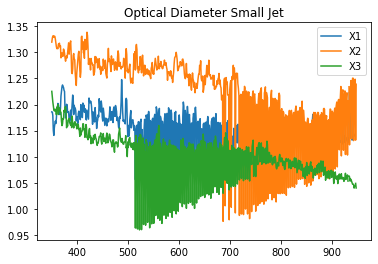

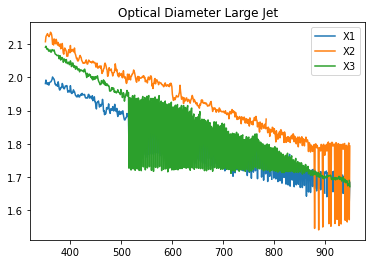

In [5]:
# Plot Optical Diameters
plt.plot(X1_small['Axial Position'][351:949], X1_small['Actual Diameter'][351:949], label='X1')
plt.plot(X2_small['Axial Position'][351:949], X2_small['Actual Diameter'][351:949], label='X2')
plt.plot(X3_small['Axial Position'][351:949], X3_small['Actual Diameter'][351:949], label='X3')
plt.title('Optical Diameter Small Jet')
plt.legend()
plt.show()

plt.plot(X1_large['Axial Position'][351:949], X1_large['Actual Diameter'][351:949], label='X1')
plt.plot(X2_large['Axial Position'][351:949], X2_large['Actual Diameter'][351:949], label='X2')
plt.plot(X3_large['Axial Position'][351:949], X3_large['Actual Diameter'][351:949], label='X3')
plt.title('Optical Diameter Large Jet')
plt.legend()
plt.show()

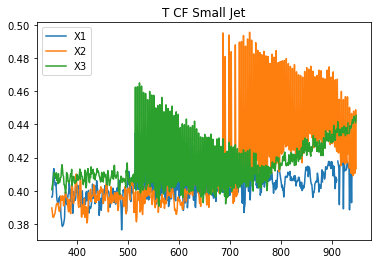

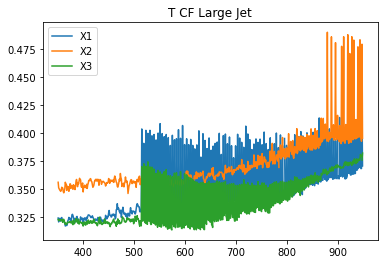

In [6]:
# Plot the T CF results
plt.plot(X1_small['Axial Position'][351:949], X1_small['T CF'][351:949], label='X1')
plt.plot(X2_small['Axial Position'][351:949], X2_small['T CF'][351:949], label='X2')
plt.plot(X3_small['Axial Position'][351:949], X3_small['T CF'][351:949], label='X3')
plt.title('T CF Small Jet')
plt.legend()
plt.show()

plt.plot(X1_large['Axial Position'][351:949], X1_large['T CF'][351:949], label='X1')
plt.plot(X2_large['Axial Position'][351:949], X2_large['T CF'][351:949], label='X2')
plt.plot(X3_large['Axial Position'][351:949], X3_large['T CF'][351:949], label='X3')
plt.title('T CF Large Jet')
plt.legend()
plt.show()

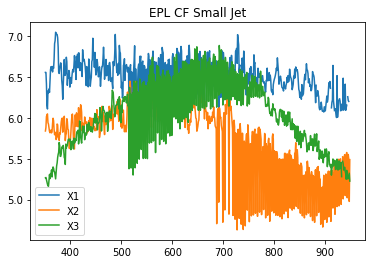

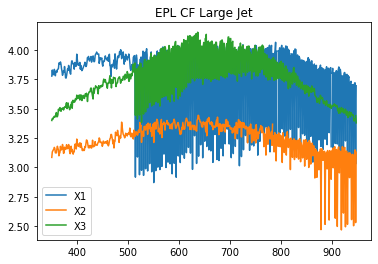

In [7]:
# Plot the EPL CF results
plt.plot(X1_small['Axial Position'][351:949], X1_small['EPL CF'][351:949], label='X1')
plt.plot(X2_small['Axial Position'][351:949], X2_small['EPL CF'][351:949], label='X2')
plt.plot(X3_small['Axial Position'][351:949], X3_small['EPL CF'][351:949], label='X3')
plt.title('EPL CF Small Jet')
plt.legend()
plt.show()

plt.plot(X1_large['Axial Position'][351:949], X1_large['EPL CF'][351:949], label='X1')
plt.plot(X2_large['Axial Position'][351:949], X2_large['EPL CF'][351:949], label='X2')
plt.plot(X3_large['Axial Position'][351:949], X3_large['EPL CF'][351:949], label='X3')
plt.title('EPL CF Large Jet')
plt.legend()
plt.show()

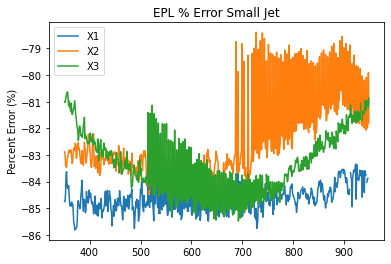

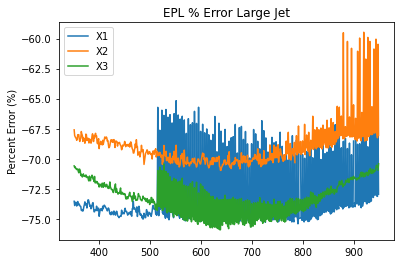

In [8]:
# Plot the EPL % Error results
plt.plot(X1_small['Axial Position'][351:949], 100*X1_small['EPL % Error'][351:949], label='X1')
plt.plot(X2_small['Axial Position'][351:949], 100*X2_small['EPL % Error'][351:949], label='X2')
plt.plot(X3_small['Axial Position'][351:949], 100*X3_small['EPL % Error'][351:949], label='X3')
plt.title('EPL % Error Small Jet')
plt.ylabel('Percent Error (%)')
plt.legend()
plt.show()

plt.plot(X1_large['Axial Position'][351:949], 100*X1_large['EPL % Error'][351:949], label='X1')
plt.plot(X2_large['Axial Position'][351:949], 100*X2_large['EPL % Error'][351:949], label='X2')
plt.plot(X3_large['Axial Position'][351:949], 100*X3_large['EPL % Error'][351:949], label='X3')
plt.title('EPL % Error Large Jet')
plt.ylabel('Percent Error (%)')
plt.legend()
plt.show()

In [9]:
# Calculate and apply the transmission correction factor to the model
# T CF calculated as actual/fitted, so Transmission * CF should give the corrected T
X1_CF = np.median(X1_small['EPL CF'][350:950])
X2_CF = np.median(X2_small['EPL CF'][350:950])
X3_CF = np.median(X3_small['EPL CF'][350:950])

# Create a corrected T2EPL function
#cs1 = CubicSpline(Transmission_ALS_50KI[::-1]/X1_T_CF, spray_epl[::-1])
#cs2 = CubicSpline(Transmission_FOS_50KI[::-1]/X2_T_CF, spray_epl[::-1])
#cs3 = CubicSpline(Transmission_ACS_50KI[::-1]/X3_T_CF, spray_epl[::-1])

# Correct the EPL2T function
#epl_to_T50KI_ALS = CubicSpline(spray_epl, Transmission_ALS_50KI/X1_T_CF)
#epl_to_T50KI_FOS = CubicSpline(spray_epl, Transmission_FOS_50KI/X2_T_CF)
#epl_to_T50KI_ACS = CubicSpline(spray_epl, Transmission_ACS_50KI/X3_T_CF)

# Save the corrected T2EPL functions
#with open('{0}/X1_T2EPL.pckl'.format(prj_fld), 'wb') as f:
#    pickle.dump(cs_ALS, f)
#    
#with open('{0}/X2_T2EPL.pckl'.format(prj_fld), 'wb') as f:
#    pickle.dump(cs_FOS, f)
#    
#with open('{0}/X3_T2EPL.pckl'.format(prj_fld), 'wb') as f:
#    pickle.dump(cs_ACS, f)

In [10]:
def proc_validation(test_path, cs, cf, epl_fld):
    # Load in image sets that were normalized in ImageJ
    data_norm = np.array(Image.open(test_path))
    
    # Offset correction
    offset = 1-np.median(data_norm[400:900, 60:200])
    data_norm += offset
    
    data_epl = np.zeros(np.shape(data_norm), dtype=float)
    cropped_view = np.linspace(
                               start=350,
                               stop=950,
                               num=950-350+1,
                               dtype=int
                               )

    for z, k in enumerate(cropped_view):
        data_epl[k, :] = cs(data_norm[k, :])

    offset_epl = np.median(data_epl[400:900, 60:200])
    data_epl -= offset_epl
    
    data_epl *= cf

    im = Image.fromarray(data_epl)
    im.save(epl_fld + '/' + test_path.rsplit('/')[-1])
    
    return

In [11]:
# Process the validation sets
epl_fld = create_folder('{0}/EPL/Validation'.format(prj_fld))
graph_fld = create_folder('{0}/Graphs/Validation/'.format(prj_fld))
width_fld = create_folder('{0}/Widths/Validation/'.format(prj_fld))
bound_fld = create_folder('{0}/Boundary/Validation'.format(prj_fld))
hdf5_fld = create_folder('{0}/HDF5/Validation/'.format(prj_fld))

# X-ray 1
X1V_small = proc_validation('{0}/Norm/Validation/X1_Small_701-1001.tif'.format(prj_fld), cs_ALS, X1_CF, epl_fld)
X1V_large = proc_validation('{0}/Norm/Validation/X1_Large_701-1001.tif'.format(prj_fld), cs_ALS, X1_CF, epl_fld)

# X-ray 2
X2V_small = proc_validation('{0}/Norm/Validation/X2_Small_701-1001.tif'.format(prj_fld), cs_FOS, X2_CF, epl_fld)
X2V_large = proc_validation('{0}/Norm/Validation/X2_Large_701-1001.tif'.format(prj_fld), cs_FOS, X2_CF, epl_fld)

# X-ray 3
X3V_small = proc_validation('{0}/Norm/Validation/X3_Small_701-1001.tif'.format(prj_fld), cs_ACS, X3_CF, epl_fld)
X3V_large = proc_validation('{0}/Norm/Validation/X3_Large_701-1001.tif'.format(prj_fld), cs_ACS, X3_CF, epl_fld)